### Visualization for Förskoleappen

This program visualize the actual attendance vs the planned attendance on several preschools (anonymized) in the Stockholm area. 

Which day do you wish to plot? (example: All or Monday etc) All
Which school number do you wish to plot? (Example: 159 163 317) 159 163


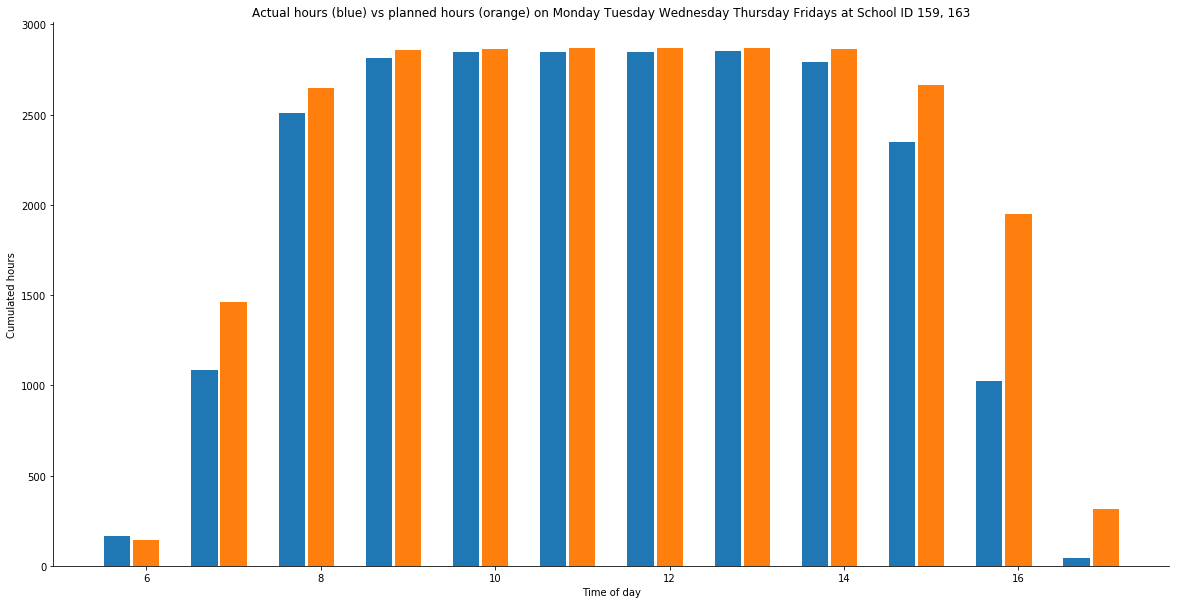

In [10]:
import pandas as pd
import numpy as np
import scipy as scipy
import datetime as dt
from collections import Counter
import matplotlib.pyplot as plt


df159 = pd.read_excel('$$Visualization rapport_159_2019-10-19.xls', header=1, usecols=[0,1,2,3,5,6,7,8,9,10])
df163 = pd.read_excel('$$Visualization rapport_163_2019-10-19.xls', header=1, usecols=[0,1,2,3,5,6,7,8,9,10])
df317 = pd.read_excel('$$Visualization rapport_317_2019-10-19.xls', header=1, usecols=[0,1,2,3,5,6,7,8,9,10])
df320 = pd.read_excel('$$Visualization rapport_320_2019-10-19.xls', header=1, usecols=[0,1,2,3,5,6,7,8,9,10])
df325 = pd.read_excel('$$Visualization rapport_325_2019-10-19.xls', header=1, usecols=[0,1,2,3,5,6,7,8,9,10])
df350 = pd.read_excel('$$Visualization rapport_350_2019-10-19.xls', header=1, usecols=[0,1,2,3,5,6,7,8,9,10])
df378 = pd.read_excel('$$Visualization rapport_378_2019-10-19.xls', header=1, usecols=[0,1,2,3,5,6,7,8,9,10])

frames = [df159, df163, df317, df320, df325, df350, df378]

df = pd.concat(frames)

df.columns = df.columns.str.replace("[$$]", "")

#freebutcheckindf = df[(df['Check-in'] != '-') & (df['FreeTime'] == 1)] #Planned free but check in anyway

df['Weekday'] = df['Date'].dt.weekday_name

dois = input('Which day do you wish to plot? (example: All or Monday etc) ')
soi = [int(x) for x in input('Which school number do you wish to plot? (Example: 159 163 317) ').split()]


if dois == 'All':
    doi = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
else:
    doi = [dois]


fdf = df[(df['Check-in'] != '-') & (df['FreeTime'] == 0) & (df['Schedule-in'] != '-') & (df['Schedule-out'] != '-') & (df['Check-out'] != '-') & (df['Weekday'].isin(doi)) & (df['SchoolId'].isin(soi))].copy()

fdf['Check-in'] = pd.to_datetime(fdf['Date'].astype(str) + ' ' +fdf['Check-in'].astype(str))
fdf['Check-out'] = pd.to_datetime(fdf['Date'].astype(str) + ' ' +fdf['Check-out'].astype(str))
fdf['Schedule-in'] = pd.to_datetime(fdf['Date'].astype(str) + ' ' +fdf['Schedule-in'].astype(str))
fdf['Schedule-out'] = pd.to_datetime(fdf['Date'].astype(str) + ' ' +fdf['Schedule-out'].astype(str))


fdf['actual'] = fdf['Check-out'] - fdf['Check-in']
fdf['planned'] = fdf['Schedule-out'] - fdf['Schedule-in']

tphours = []
tchours = []
for index, row in fdf.iterrows():
    chours = pd.PeriodIndex(start = row['Check-in'], end = row['Check-out'], freq='H').hour.tolist()
    tchours.append(chours)
    phours = pd.PeriodIndex(start = row['Schedule-in'], end = row['Schedule-out'], freq='H').hour.tolist()
    tphours.append(phours)

flat_list = []
for sublist in tchours:
    for item in sublist:
        flat_list.append(item)
        
checkcount=sorted(Counter(flat_list).items())

flat_list_2 = []
for sublist in tphours:
    for item in sublist:
        flat_list_2.append(item)

plancount=sorted(Counter(flat_list_2).items())


act_df = fdf['actual'].mean()
pla_df = fdf['planned'].mean()

act = fdf.groupby(['Weekday'])[['actual']].sum()
pla = fdf.groupby(['Weekday'])[['planned']].sum()


#print(act)
#print(pla)

fig = plt.figure(figsize=(20,10))
ax = fig.gca()

ah, noc = zip(*checkcount) # unpack a list of pairs into two tuples
ph, nop = zip(*plancount)

width = np.min(np.diff(ah))/3

doias = ' '.join(doi)
soias = ', '.join([str(i) for i in soi])



plt.bar(ah-width, noc, width = 0.3)
plt.bar(ph, nop, width = 0.3)
ax.set_title('Actual hours (blue) vs planned hours (orange) on {}s at School ID {}'.format(doias, soias))
plt.xlabel('Time of day')
plt.ylabel('Cumulated hours')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


plt.savefig('attendanceALL.png', dpi=125, bbox_inches='tight')



plt.show()



